<h4 style="margin:0;"><b>Maciej Bogusławski (331362), Hubert Kaczyński (331386)</b></h4>
<h1 style="margin:0;"><b>Inżynieria Uczenia Maszynowego</b></h1>
<p style="margin-top:0.4rem;"><b>Projekt 6. Etap 2. Ewaluacja testu A/B</b></p>

Niniejszy notatnik stanowi element drugiego etapu projektu realizowanego w ramach przedmiotu Inżynieria Uczenia Maszynowego w realizacji 25Z. Celem niniejszego notatnika jest analiza wyników testu A/B dla mikroserwisu "Nocarz Price Prediction API" zbudowanego w ramach projektu. Test ma na celu porównanie dwóch modeli predykcji cen noclegów - modelu bazowego, stanowiącego model regresji liniwoej wykorzystujący do predykcji podstawowe cechy nieruchomości, oraz modelu zaawansowanego, czyli modelu random forest wykorzystującego do predykcji dodatkowe cechy w postaci informacji o obecności w nieruchomości najbardziej wpływajacych na cenę udogodnień.

## **Konfiguracja**

W celu pobrania wyników testu A/B z mikroserwisu, konieczne jest uruchomienie mikroserwisu. Aby umożliwić jak najłatwiejsze uruchomienie aplikacji, mikroserwis przygotowany w ramach etapu drugiego projektu został skonteneryzowany z pomocą narzędzia Docker. Dzięki temu uruchomienie aplikacji w środowisku "produkcyjnym" możliwe jest z pomocą następującej pojedynczej linijki, uruchamiajacej jednocześnie bazę PostgreSQL na porcie 5436 oraz API na porcie 8080:

```bash
docker compose up
```

Poniższy kod importuje niezbędne do analizy, wizualizacji i komunikacji z API biblioteki oraz tworzy przydatne do przechowywania wyników klasy.

In [20]:
import sys
from dataclasses import dataclass

import requests
import numpy as np
import matplotlib.pyplot as plt

DEFAULT_URL = "http://localhost:8080"

@dataclass
class ModelMetrics:
    model_type: str
    num_predictions: int
    num_evaluated: int
    mae: float | None
    rmse: float | None
    r2: float | None
    mean_predicted_price: float | None
    mean_actual_price: float | None

    @property
    def has_data(self) -> bool:
        return self.num_evaluated > 0 and self.mae is not None

    @property
    def mae_relative(self) -> float | None:
        if self.mae and self.mean_actual_price:
            return self.mae / self.mean_actual_price * 100
        return None

@dataclass
class ABTestResults:
    total_predictions: int
    total_evaluated: int
    baseline: ModelMetrics
    advanced: ModelMetrics

    @classmethod
    def from_api_response(cls, data: dict) -> "ABTestResults":
        return cls(
            total_predictions=data["total_predictions"],
            total_evaluated=data["total_evaluated"],
            baseline=ModelMetrics(**data["baseline"]),
            advanced=ModelMetrics(**data["advanced"]),
        )

Poniższy kod zawiera dodatkowo przydatne funkcje pomocnicze.

In [21]:
def print_header(title: str) -> None:
    print("\n" + "=" * 50)
    print(title)
    print("=" * 50 + "\n")

def format_metric(val: float | None, prefix: str="$") -> str:
    if val is None:
        return "N/A"
    if prefix == "$":
        return f"${val:,.2f}"
    elif prefix == "%":
        return f"{val:.2f}%"
    return f"{val:.2f}"

def print_results(name: str, metrics: ModelMetrics) -> None:
    print(f"\nModel: {name}")
    print(f"  Number of predictions made: {metrics.num_predictions}")
    print(f"  Number of predictions evaluated: {metrics.num_evaluated}")
    if metrics.has_data:
        print(f"  Mean Absolute Error (MAE): {format_metric(metrics.mae)}")
        print(f"  Root Mean Squared Error (RMSE): {format_metric(metrics.rmse)}")
        print(f"  R-squared (R2): {format_metric(metrics.r2, prefix='')}")
        print(f"  Mean Predicted Price: {format_metric(metrics.mean_predicted_price)}")
        print(f"  Mean Actual Price: {format_metric(metrics.mean_actual_price)}")
        print(f"  MAE Relative to Mean Actual Price: {format_metric(metrics.mae_relative, prefix='%')}")
    else:
        print("  No evaluation data available.")

Aby niniejsza ewaluacja testu A/B zwróciła cenne wyniki, należy uprzednio zasymulować wykorzystanie mikroserwisu po wdrożeniu produkcyjnym na platformie Nocarz. W tym celu rekomendowane jest użycie skryptu `run_ab_test.py` w folderze `scripts`, symulującego działanie użytkowników na platformie na podstawie danych testowych. Istnieje jednak możliwość samodzielnego zasymulowania działania użytkownika na platformie. W tym celu rekomendowane jest co najmniej kilkukrotne wykoanie następujących kroków:

**Krok 1. Uzyskanie predykcji ceny**
Wykorzystując endpoint `GET /nocarz/predict`, należy uzyskać predykcję ceny dla wybranych parametrów, przekazywanych przez query string. Przykładowe wywołanie:
```
http://127.0.0.1:8080/nocarz/predict?accommodates=6&room_type=Entire%20home&property_type=Entire%20villa&neighbourhood_cleansed=Llucmajor
```

W odpowiedzi mikroserwis zwraca przewidywaną cenę noclegu za noc wraz z ID wykonanej predykcji, np.:
```json
{
  "prediction_id": "c102eee7-b68a-42c9-a4c6-bc36027dbae3",
  "predicted_price": 310.4306223019588
}
```

**Krok 2. Ustawienie faktycznej ceny**
Po uzyskaniu predykcji, możliwe jest ustawienie rzeczywistej ceny za noc. W tym celu należy wykorzystać endpoint `POST /nocarz/set_price`, wymagający podania finalnej ceny oraz ID uprzedniej predykcji w request body, np.:

```json
{
  "prediction_id": "c102eee7-b68a-42c9-a4c6-bc36027dbae3",
  "actual_price": 415
}
```

Wykonanie tych kroków symuluje wykorzystanie mikroserwisu na platformie Nocarz w środowisku produkcyjnym, w którym gospodarz lokalu najpierw podaje parametry nieruchomości (dzielnica, liczba gości, łazienek itp.), otrzymuje proponowaną cenę noclegu za noc, a następnie samodzielnie ustawia finalną wartość, pozwalając w ten sposób stwierdzić jakość uprzedniej predykcji.

Wykonanie wyżej wymienionych kroków ułatwia wykorzystanie narzędzia Postman bądź automatyczna dokumentacja Swagger UI, dostępna po uruchomieniu mikroserwisu w trybie deweloperskim na `http://127.0.0.1:8080/docs`.


## **Komunikacja z API**

Po uruchomieniu mikroserwisu, należy sprawdzić, czy komunikacja z API przebiega poprawnie. W tym celu można wykorzystać endpoint `/nocarz/health`, udzielający informację o dostępności API oraz statusie załadowania modeli.

In [22]:
try:
    response = requests.get(f"{DEFAULT_URL}/nocarz/health", timeout=5)
    print("Service health check:", response.json())
except requests.exceptions.ConnectionError:
    print("Error: Could not connect to the service at", DEFAULT_URL)
    sys.exit(1)
except requests.exceptions.Timeout:
    print("Error: Connection to the service at", DEFAULT_URL, "timed out.")
    sys.exit(1)


Service health check: {'status': 'ok', 'models_loaded': True}


Jeśli uruchomienie mikroserwisu przebiegło pomyślnie, uzyskana odpowiedź wyglądać powinna w następujący sposób:

```text
Service health check: {'status': 'ok', 'models_loaded': True}
```

Po uzyskaniu potwierdzenia poprawnego działania oraz wykonaniu "symulacji" działania mikroserwisu należy pobrać wyniki testu A/B z API. W tym celu wykorzystać należy endpoint `GET /nocarz/results`.

In [23]:
response = requests.get(f"{DEFAULT_URL}/nocarz/results", timeout=10)
if response.status_code != 200:
    print("Error: Failed to fetch A/B test results from the service.")
    sys.exit(1)

ab_test_results = ABTestResults.from_api_response(response.json())

print_header("A/B Test Results Summary")
print(f"Total Predictions Made: {ab_test_results.total_predictions}")
print(f"Total Predictions Evaluated: {ab_test_results.total_evaluated}")

if ab_test_results.total_predictions == 0:
    print("No predictions were made during the A/B test.")
    print("Please make predictions using GET /nocarz/predict endpoint and try again.")
    sys.exit(0)

eval_percent = (ab_test_results.total_evaluated / ab_test_results.total_predictions) * 100
print(f"Evaluation Coverage: {eval_percent:.2f}%")

print_results("Baseline Model", ab_test_results.baseline)
print_results("Advanced Model", ab_test_results.advanced)



A/B Test Results Summary

Total Predictions Made: 2667
Total Predictions Evaluated: 2642
Evaluation Coverage: 99.06%

Model: Baseline Model
  Number of predictions made: 1310
  Number of predictions evaluated: 1297
  Mean Absolute Error (MAE): $112.33
  Root Mean Squared Error (RMSE): $174.27
  R-squared (R2): 0.35
  Mean Predicted Price: $262.34
  Mean Actual Price: $262.09
  MAE Relative to Mean Actual Price: 42.86%

Model: Advanced Model
  Number of predictions made: 1357
  Number of predictions evaluated: 1345
  Mean Absolute Error (MAE): $101.70
  Root Mean Squared Error (RMSE): $163.91
  R-squared (R2): 0.50
  Mean Predicted Price: $264.28
  Mean Actual Price: $270.23
  MAE Relative to Mean Actual Price: 37.63%


## **Analiza porównawcza**

Poniższy kod analizuje poprawę modelu zaawansowanego względem bazowego.

In [24]:
if not ab_test_results.baseline.has_data or not ab_test_results.advanced.has_data:
    print("\nInsufficient evaluation data to compare models.")
    sys.exit(0)

if not ab_test_results.baseline.mae or not ab_test_results.advanced.mae:
    print("\nMAE data missing for one of the models; cannot compare.")
    sys.exit(0)

print_header("A/B Test Model Comparison")

mae_diff = ab_test_results.baseline.mae - ab_test_results.advanced.mae
mae_diff_pct = (mae_diff / ab_test_results.baseline.mae) * 100

print(f"MAE Improvement of Advanced Model over Baseline: {format_metric(mae_diff)} ({mae_diff_pct:.2f}%)")

if mae_diff > 0:
    print("The Advanced Model outperformed the Baseline Model.")
elif mae_diff < 0:
    print("The Baseline Model outperformed the Advanced Model.")
else:
    print("Both models performed equally well.")

if ab_test_results.advanced.r2 and ab_test_results.baseline.r2:
    r2_diff = ab_test_results.advanced.r2 - ab_test_results.baseline.r2
    print(f"R2 Improvement of Advanced Model over Baseline: {format_metric(r2_diff, prefix='')}")
else:
    print("R2 data missing for one of the models; cannot compare R2 performance.")


A/B Test Model Comparison

MAE Improvement of Advanced Model over Baseline: $10.63 (9.46%)
The Advanced Model outperformed the Baseline Model.
R2 Improvement of Advanced Model over Baseline: 0.15


Poniższy kod generuje zestaw wykresów porównujących wyniki testu A/B dla obu modeli. Wizualizacje obejmują porównanie liczby predykcji i ewaluacji, porównanie MAE i RMSE, porównanie współczynnika $R^2$ oraz porównanie średnich cen prewidywanych w porównaniu do rzeczywistych.

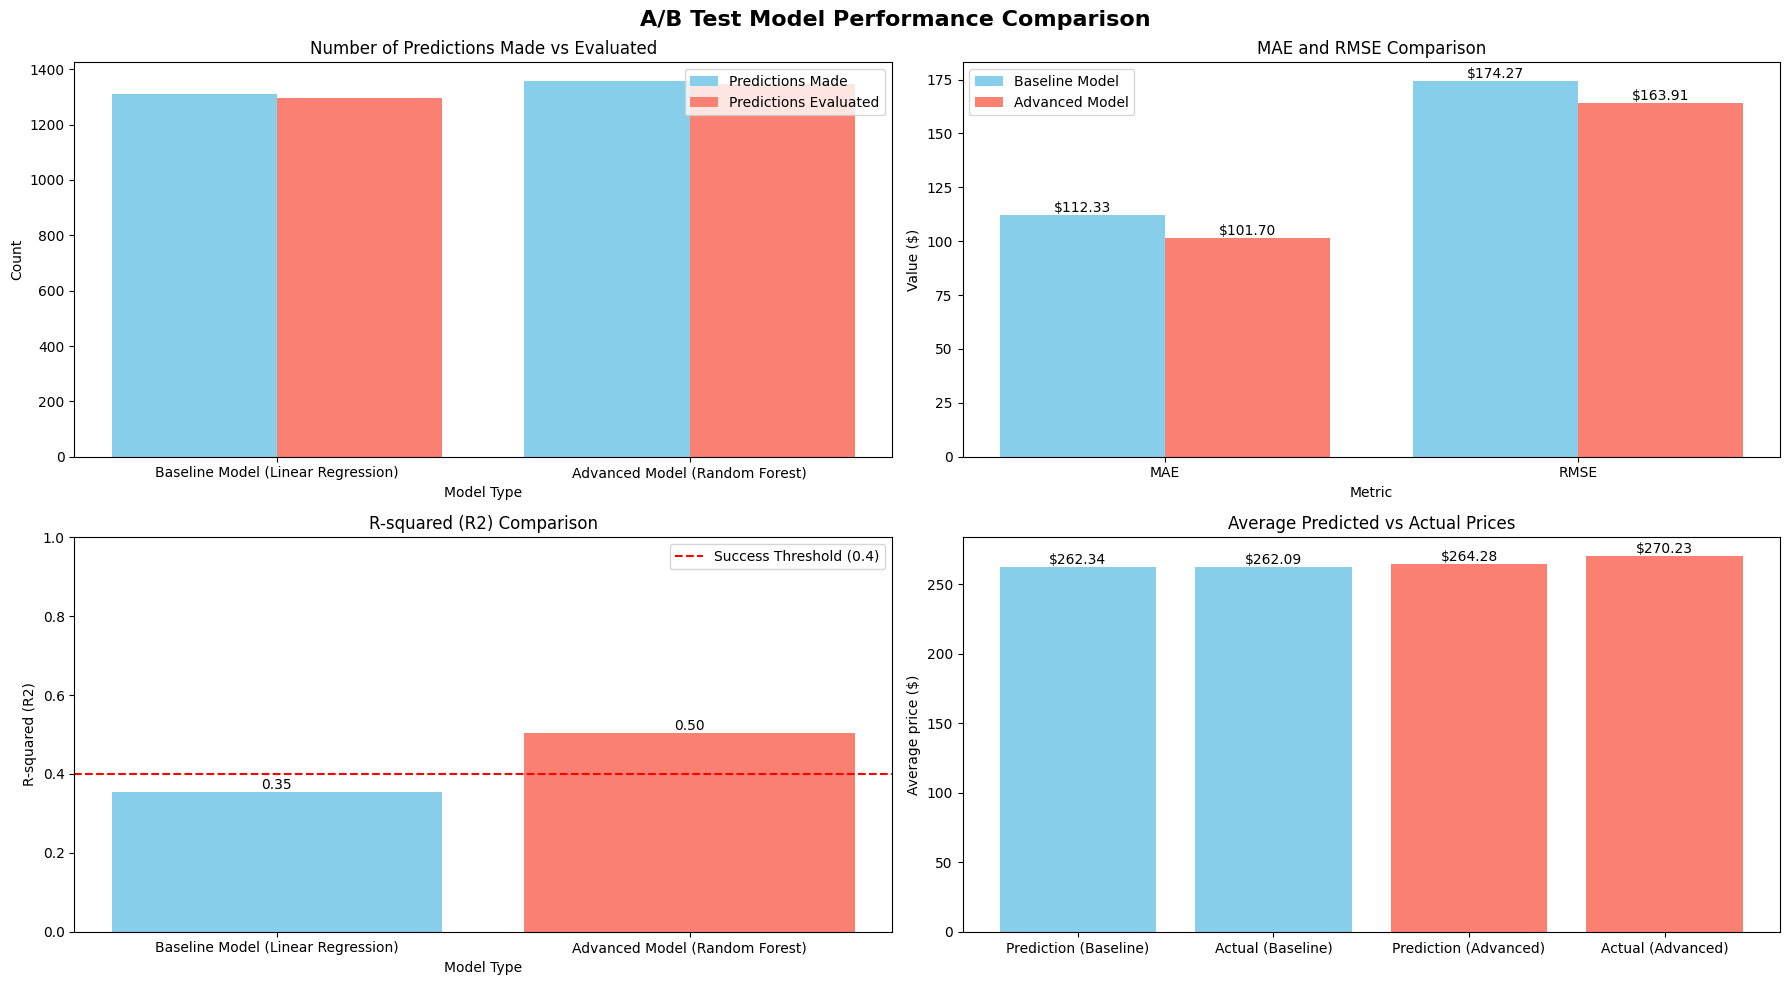

In [25]:
if not ab_test_results.baseline.has_data or not ab_test_results.advanced.has_data:
    print("\nInsufficient evaluation data to compare models.")
    sys.exit(0)

fig, axes = plt.subplots(2, 2, figsize=(18, 10))
fig.suptitle("A/B Test Model Performance Comparison", fontsize=16, fontweight="bold")

colors = {"baseline": "skyblue", "advanced": "salmon"}
model_names = ["Baseline Model (Linear Regression)", "Advanced Model (Random Forest)"]

# Plot 1: Number of Predictions Made vs Evaluated
ax1 = axes[0, 0]
x = np.arange(2)
width = 0.4

predictions_counts = [ab_test_results.baseline.num_predictions, ab_test_results.advanced.num_predictions]
evaluated_counts = [ab_test_results.baseline.num_evaluated, ab_test_results.advanced.num_evaluated]

ax1.bar(x - width/2, predictions_counts, width, label="Predictions Made", color=colors["baseline"])
ax1.bar(x + width/2, evaluated_counts, width, label="Predictions Evaluated", color=colors["advanced"])
ax1.set_xticks(x)
ax1.set_xticklabels(model_names)
ax1.set_xlabel("Model Type")
ax1.set_ylabel("Count")
ax1.set_title("Number of Predictions Made vs Evaluated")
ax1.legend()

# Plot 2: MAE and RMSE Comparison
ax2 = axes[0, 1]
metric_names = ["MAE", "RMSE"]
baseline_vals = [ab_test_results.baseline.mae or 0, ab_test_results.baseline.rmse or 0]
advanced_vals = [ab_test_results.advanced.mae or 0, ab_test_results.advanced.rmse or 0]

x = np.arange(len(metric_names))
bars1 = ax2.bar(x - width/2, baseline_vals, width, label="Baseline Model", color=colors["baseline"])
bars2 = ax2.bar(x + width/2, advanced_vals, width, label="Advanced Model", color=colors["advanced"])
ax2.set_xticks(x)
ax2.set_xticklabels(metric_names)
ax2.set_xlabel("Metric")
ax2.set_ylabel("Value ($)")
ax2.set_title("MAE and RMSE Comparison")
ax2.legend()

for bar, val in zip(bars1, baseline_vals):
    if val > 0:
        ax2.text(bar.get_x() + bar.get_width() / 2, bar.get_height(), f"${val:,.2f}", ha='center', va='bottom')
for bar, val in zip(bars2, advanced_vals):
    if val > 0:
        ax2.text(bar.get_x() + bar.get_width() / 2, bar.get_height(), f"${val:,.2f}", ha='center', va='bottom')

# Plot 3: R2 Comparison
ax3 = axes[1, 0]
r2_vals = [
    ab_test_results.baseline.r2 or 0,
    ab_test_results.advanced.r2 or 0,
]
bars = ax3.bar(model_names, r2_vals, color=[colors["baseline"], colors["advanced"]])
ax3.set_xlabel("Model Type")
ax3.set_ylabel("R-squared (R2)")
ax3.set_title("R-squared (R2) Comparison")
ax3.set_ylim(0, 1)

ax3.axhline(y=0.4, color="r", linestyle="--", label="Success Threshold (0.4)")
ax3.legend()

for bar, val in zip(bars, r2_vals):
    if val > 0:
        ax3.text(bar.get_x() + bar.get_width() / 2, bar.get_height(), f"{val:.2f}", ha='center', va='bottom')

# Plot 4: Average Predicted vs Actual Prices
ax4 = axes[1, 1]
labels = ["Prediction (Baseline)", "Actual (Baseline)", "Prediction (Advanced)", "Actual (Advanced)"]
values = [
    ab_test_results.baseline.mean_predicted_price or 0,
    ab_test_results.baseline.mean_actual_price or 0,
    ab_test_results.advanced.mean_predicted_price or 0,
    ab_test_results.advanced.mean_actual_price or 0,
]
bar_colors = [colors["baseline"], colors["baseline"], colors["advanced"], colors["advanced"]]
bars = ax4.bar(labels, values, color=bar_colors)
ax4.set_ylabel("Average price ($)")
ax4.set_title("Average Predicted vs Actual Prices")

for bar, val in zip(bars, values):
    if val > 0:
        ax4.text(bar.get_x() + bar.get_width() / 2, bar.get_height(), f"${val:,.2f}", ha='center', va='bottom')

plt.tight_layout()

Na podstawie przedstawionych wykresów można ocenić różnice w skuteczności obu modeli. Analiza liczby ocenionych predykcji, metryk MAE/RMSE oraz współczynnika $R^2$ pozwala określić, czy model zaawansowany oferuje istotną poprawę jakości predykcji względem bazowego modelu regresji liniowej.